# SED plots and color images

This notebook extract the point source photometry from the deconvolved model, produce the SED plots and final color images (reproduce Figure 9,10 and Table 3 of Millon et al. (2024)). 

By [Martin Millon](https://martin-millon.gitlab.io), February 2023.

In [27]:
# Parameters
bands = ['f090w', 'f150w', 'f200w', 'f277w','f356w','f444w']
bands_maj = ['F090W', 'F150W', 'F200W', 'F277W','F356W','F444W']
wavelenght = [900, 1500, 2000, 2770, 3560, 4440]
mas = '40mas'
noise_key = 'errWPC' # use 'errWPC'

subsampling_factor = 2
noise_map_type = 'rms'
method_deconv = 'adabelief'
lambda_scales = 3.
lambda_hf = [10., 50.] #Nircam red arms requires some higher regularisation

combined = True
show_old_measurements = True 
N_new = 18

In [28]:
import numpy as np 
import os
import json 
from astropy.io import fits
import matplotlib.pyplot as plt 
from texttable import Texttable
import latextable
import pandas as pd

import matplotlib as mpl 
from matplotlib import rc
import json

mpl.rcParams['axes.labelsize']= 18

mpl.rcParams['xtick.labelsize']= 14
mpl.rcParams['xtick.direction']= 'in'
mpl.rcParams['xtick.top']= True
mpl.rcParams['xtick.minor.visible']=  True
mpl.rcParams['xtick.major.size']=  7
mpl.rcParams['xtick.minor.size']=  3

mpl.rcParams['ytick.labelsize']=  14
mpl.rcParams['ytick.direction']= 'in'
mpl.rcParams['ytick.right']=  True
mpl.rcParams['ytick.minor.visible']=  True
mpl.rcParams['ytick.major.size']=  7
mpl.rcParams['ytick.minor.size']=  3

mpl.rcParams['legend.numpoints']=  1
mpl.rcParams['legend.facecolor']=  'None'
mpl.rcParams['legend.edgecolor']=  'None'
mpl.rcParams['legend.fontsize']=  18

rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)

from utils_plots import prepare_image, choose_color
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [29]:
deconv_names = [] 
for band in bands: 
    if band in ['f277w','f356w','f444w'] and combined: 
        lambda_hf_use = lambda_hf[1]
        deconv_names.append('deconv_lambda%2.2f_%2.2f_%s_sub%i'%(lambda_scales, lambda_hf_use, noise_map_type, subsampling_factor))
    else: 
        lambda_hf_use = lambda_hf[0]
        deconv_names.append('deconv_lambda%2.2f_%2.2f_%s_sub%i'%(lambda_scales, lambda_hf_use, noise_map_type, subsampling_factor))

if combined:
    output_folder = './results/combined_final_lambda%2.2f_%2.2f-%2.2f_%s_sub%i'%(lambda_scales, lambda_hf[0], lambda_hf[1], noise_map_type, subsampling_factor)
else:
    output_folder = './results/deconv_lambda%2.2f_%2.2f_%s_sub%i'%(lambda_scales, lambda_hf[0], noise_map_type, subsampling_factor)
os.makedirs(output_folder, exist_ok=True)

print(len(deconv_names))

6


# Comparison with aperture photometry

Comparison with the photometry measured in [Mowla et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...937L..35M/abstract)

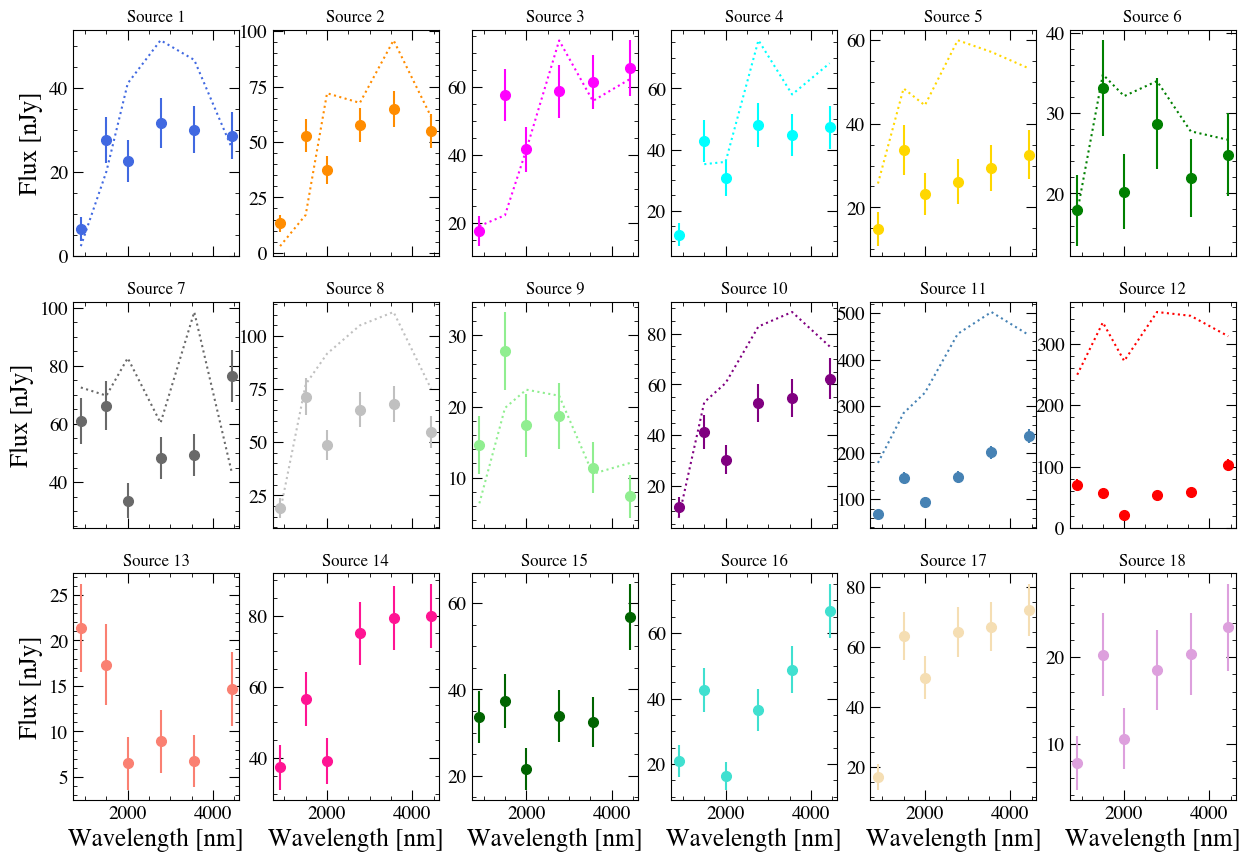

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./results/combined_final_lambda3.00_10.00-50.00_rms_sub2/SED_source_all.pdf'.


0

In [30]:
# import previous table
df = pd.read_csv("table.txt", header=0, delimiter=' ')
ra = df['RA'].values 
dec= df['DEC'].values
N_old = len(ra)

SED_old = np.zeros((N_old, len(bands)))* np.nan
SED_new = np.zeros((N_new, len(bands)))* np.nan
SED_err = np.zeros((N_new, len(bands)))* np.nan
x = np.zeros((N_new, len(bands)))* np.nan
y = np.zeros((N_new, len(bands)))* np.nan
x_init = np.zeros((N_new, len(bands))) * np.nan
y_init = np.zeros((N_new, len(bands))) * np.nan
RA = [['s' for _ in range(len(bands))] for _ in range(N_new)]
DEC = [['s' for _ in range(len(bands))] for _ in range(N_new)]

for i in range(N_new):
    for j, band in enumerate(bands): 
        photom_key = f'{band}_flux_nJy'
        photom_key_err = f'{band}_flux_nJy' + '_' + noise_key 
        if i< N_old: 
            SED_old[i,j] = df[photom_key].values[i]

        deconv_path = os.path.join('./', band, 'deconvolution', deconv_names[j])
        try : 
            with open(os.path.join(deconv_path, 'photom.json'), 'r') as f : 
                m = json.load(f)

            SED_new[i,j] = max(m[photom_key][i],0)
            SED_err[i,j] = m[photom_key_err][i]
            RA[i][j]=m['RA'][i]
            DEC[i][j]=m['DEC'][i]
            x[i,j] = m['x_pos'][i]
            y[i,j] = m['y_pos'][i]
            x_init[i,j] = m['x_pos_init'][i]
            y_init[i,j] = m['y_pos_init'][i]
        except FileNotFoundError: 
            print('Missing deconvolution :', os.path.join(deconv_path, 'photom.json')) 
            SED_new[i,j] = np.nan 
            SED_err[i,j] = np.nan

#plotting SED 
color = ['royalblue', 'darkorange', 'magenta', 'cyan', 'gold', 'green', 'dimgrey', 'silver', 'lightgreen', 'purple', 'steelblue', 'red', 'salmon','deeppink','darkgreen',
         'turquoise', 'wheat', 'plum']

fig1, axes = plt.subplots(3,6, figsize = (15,10), sharex=True, sharey=False)
axes = np.ravel(axes)
for i in range(N_new): 
    axes[i].set_title('Source %i'%(i+1))
    if show_old_measurements and i < N_old: 
        axes[i].plot(wavelenght, SED_old[i,:], linestyle=':', color=color[i], label=f'Source {i}')
    axes[i].errorbar(wavelenght, SED_new[i,:], yerr=SED_err[i,:], mfc=color[i], mec=color[i], linestyle='none', ms =7, marker='o', ecolor=color[i])

    if i>=12: 
        axes[i].set_xlabel('Wavelength [nm]')   
    if i %6==0: 
        axes[i].set_ylabel('Flux [nJy]')
    # axes[i].legend()

# fig1.delaxes(axes[-1])
plt.show()

fig1name = os.path.join(output_folder, 'SED_source_all.pdf')
fig1namepng= os.path.join(output_folder, 'SED_source_all.png')
fig1.savefig(fig1name, dpi=300)
fig1.savefig(fig1namepng, dpi=300)
os.system('pdfcrop %s %s'%(fig1name, fig1name))


# Check Astrometry

We verify that the astrometry of the point sources is compatbile across the bands. We have sub-pixel errors for all of them. Source #13 is undetected in most of the redest bands, leading to higher astrometric error. 

Astrometric precision source 1 : 0.10259250499631785
Astrometric precision source 2 : 0.1447688216213373
Astrometric precision source 3 : 0.08291031669763133
Astrometric precision source 4 : 0.09363262061034101
Astrometric precision source 5 : 0.16226150945653947
Astrometric precision source 6 : 0.22557531534752973
Astrometric precision source 7 : 0.15713535117521432
Astrometric precision source 8 : 0.07939093244346779
Astrometric precision source 9 : 0.5782420250801046
Astrometric precision source 10 : 0.07003168736029727
Astrometric precision source 11 : 0.07697412781162231
Astrometric precision source 12 : 0.2603317477091157
Astrometric precision source 13 : 0.538606000499306
Astrometric precision source 14 : 0.15200647590903307
Astrometric precision source 15 : 0.39138750664348987
Astrometric precision source 16 : 0.07635577066438545
Astrometric precision source 17 : 0.13219331341080137
Astrometric precision source 18 : 0.12002308225926525


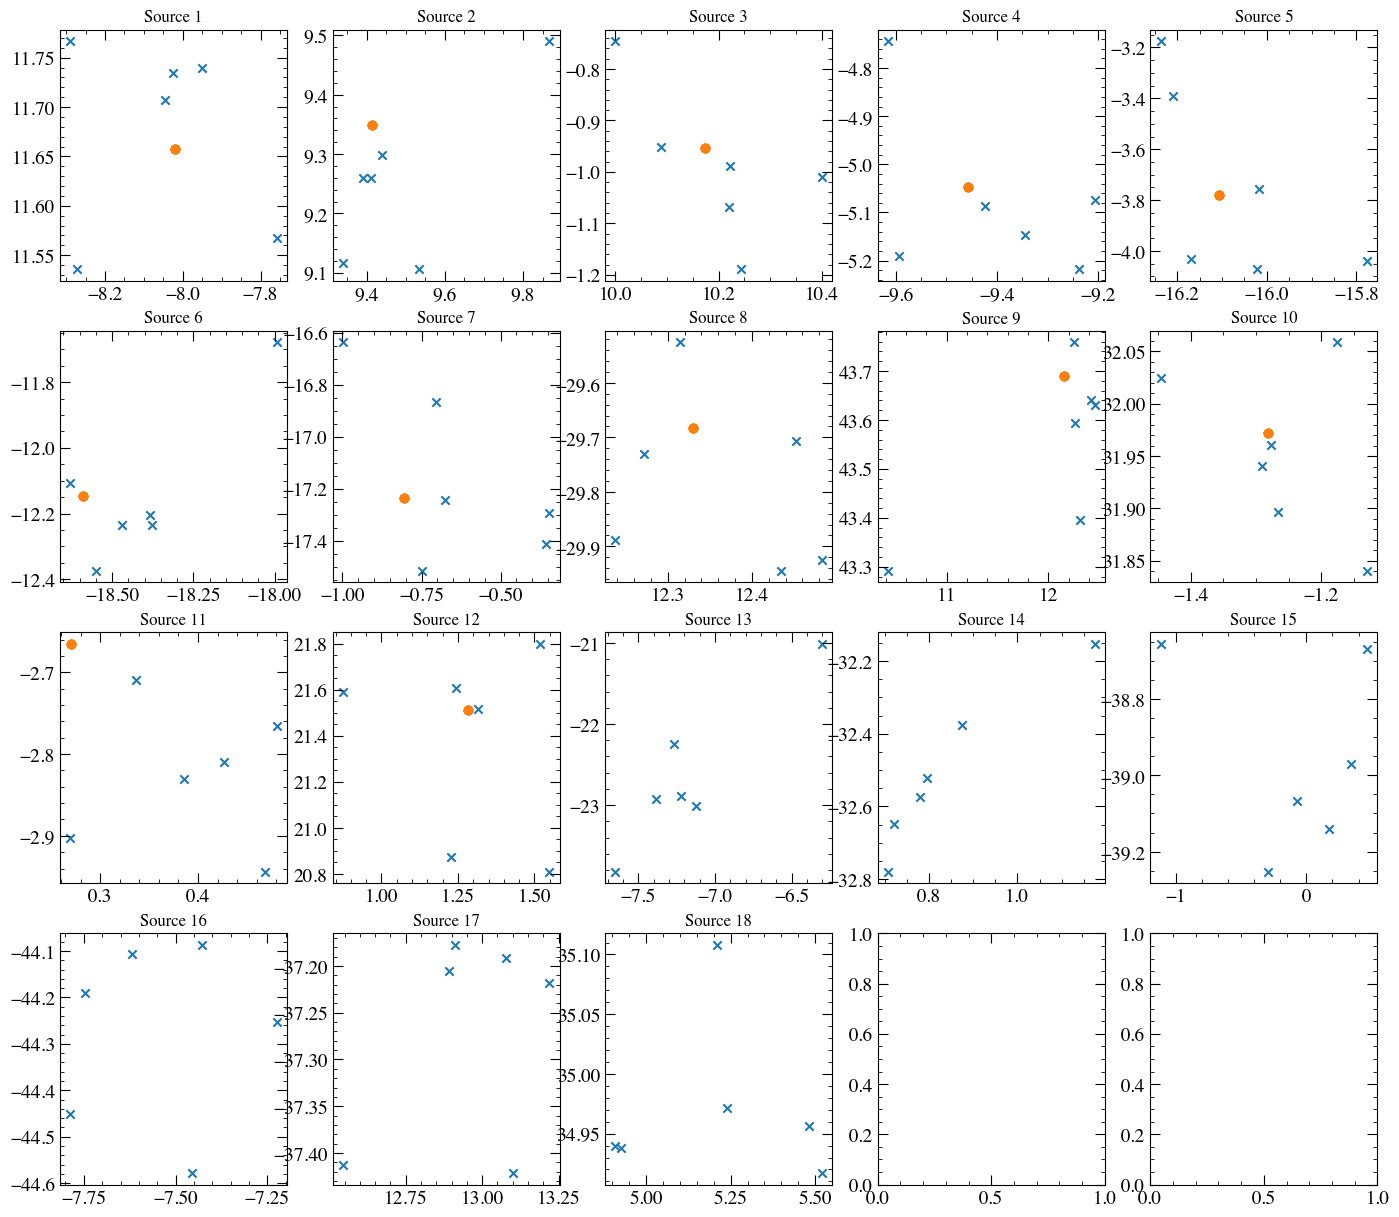

In [31]:
astrom_offset = np.sqrt((x - x_init)**2 + (y - y_init)**2)
dx = x - x_init
dy = y - y_init 

fig2, axes = plt.subplots(4,5, figsize = (17,15))
axes = np.ravel(axes)
for i in range(N_new): 
    axes[i].set_title('Source %i'%(i+1))
    axes[i].scatter(x[i,:], y[i,:], marker='x') 

    if i < N_old: 
        axes[i].scatter(x_init[i,:], y_init[i,:], marker='o')

    precision = np.nanstd(astrom_offset[i,:])
    mean_x = np.nanmean(x[i,:])
    mean_y = np.nanmean(y[i,:])
    print(f'Astrometric precision source {i+1} : {precision}')

fig2.savefig(os.path.join(output_folder, 'Astrometric_precision.pdf'), dpi=300)

## make a LAtex Table 
Reproduce Table 3 of Millon et al. (2024)

In [32]:
# make a LAtex Table 
table = [['ID', 'RA', 'DEC']]
tableObj = Texttable()
colalign = ["l", "c", "c",]
coldtype = ["t", "t", "t"]

for band in bands_maj: 
    table[0].append(band + ' [nJy]')
    colalign.append("c")
    coldtype.append("t")
    
# Set columns 
tableObj.set_cols_align(colalign) 

# # Set datatype of each column 
tableObj.set_cols_dtype(coldtype) 

#for now RA DEC of the F444w band TODO 
for i in range(N_new): 
    row = [f'{i+1}', f'{RA[i][-1][:13]}', f'{DEC[i][-1][:14]}']
    for j,band in enumerate(bands):
        row.append(f'{SED_new[i,j]:2.1f} $\pm$ {SED_err[i,j]:2.1f}')
    table.append(row)

tableObj.add_rows(table)
# print(tableObj.draw())  

print(latextable.draw_latex(tableObj, caption="SED sparkler", label="tab:SED_sparkler"))


\begin{table}
	\begin{center}
		\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
			\hline
			ID & RA & DEC & F090W [nJy] & F150W [nJy] & F200W [nJy] & F277W [nJy] & F356W [nJy] & F444W [nJy] \\
			\hline
			1 & 07:23:21.8648 & -73:27:18.2528 & 6.5 $\pm$ 2.9 & 27.6 $\pm$ 5.5 & 22.6 $\pm$ 4.9 & 31.6 $\pm$ 5.9 & 30.0 $\pm$ 5.6 & 28.6 $\pm$ 5.5 \\
			\hline
			2 & 07:23:21.6948 & -73:27:18.3440 & 13.3 $\pm$ 3.9 & 52.8 $\pm$ 7.4 & 37.2 $\pm$ 6.2 & 57.7 $\pm$ 7.8 & 64.9 $\pm$ 8.2 & 54.9 $\pm$ 7.5 \\
			\hline
			3 & 07:23:21.6927 & -73:27:18.7617 & 17.6 $\pm$ 4.4 & 57.6 $\pm$ 7.7 & 41.7 $\pm$ 6.6 & 58.8 $\pm$ 7.8 & 61.5 $\pm$ 7.9 & 65.6 $\pm$ 8.2 \\
			\hline
			4 & 07:23:21.8770 & -73:27:18.9312 & 12.2 $\pm$ 3.8 & 42.8 $\pm$ 6.7 & 30.7 $\pm$ 5.7 & 48.1 $\pm$ 7.1 & 44.7 $\pm$ 6.8 & 47.3 $\pm$ 7.0 \\
			\hline
			5 & 07:23:21.9393 & -73:27:18.8505 & 14.8 $\pm$ 4.1 & 33.6 $\pm$ 6.0 & 23.1 $\pm$ 5.0 & 26.2 $\pm$ 5.4 & 29.5 $\pm$ 5.6 & 32.5 $\pm$ 5.9 \\
			\hline
			6 & 07:23:21.9557 & -73:27:19.1906 & 17.

## Create color images from the 3 Near-IR bands
Reproduce Fig 9.

In [33]:
# RGB image
r_band = 'f200w'
g_band = 'f150w'
b_band = 'f090w'

select_color_cut = False

data_file = os.path.join('./', r_band, 'deconvolution', deconv_names[0], 'data_00000.fits')
deconv_file = os.path.join('./', r_band, 'deconvolution', deconv_names[0], 'deconvolution_00000.fits')
back_file = os.path.join('./', r_band, 'deconvolution', deconv_names[0], 'background_model.fits')
R = fits.open(data_file)[0].data
R_dec = fits.open(deconv_file)[0].data
R_back = fits.open(back_file)[0].data
im_size, _ = np.shape(R)
im_size_up, _ = np.shape(R_dec)

data_file = os.path.join('./', g_band, 'deconvolution', deconv_names[0], 'data_00000.fits')
deconv_file = os.path.join('./', g_band, 'deconvolution', deconv_names[0], 'deconvolution_00000.fits')
back_file = os.path.join('./', g_band, 'deconvolution', deconv_names[0], 'background_model.fits')
G = fits.open(data_file)[0].data
G_dec = fits.open(deconv_file)[0].data
G_back = fits.open(back_file)[0].data

data_file = os.path.join('./', b_band, 'deconvolution', deconv_names[0], 'data_00000.fits')
deconv_file = os.path.join('./', b_band, 'deconvolution', deconv_names[0], 'deconvolution_00000.fits')
back_file = os.path.join('./', b_band, 'deconvolution', deconv_names[0], 'background_model.fits')
B = fits.open(data_file)[0].data
B_dec = fits.open(deconv_file)[0].data
B_back = fits.open(back_file)[0].data

R_dec *= subsampling_factor**2
G_dec *= subsampling_factor**2
B_dec *= subsampling_factor**2

R_back *= subsampling_factor**2
G_back *= subsampling_factor**2
B_back *= subsampling_factor**2

#select color cuts: 
coef_a = np.asarray([-0.39617723718505626, -0.2528236316246737, -0.8262380538662031]) - 0.25
coef_m = np.asarray([2.502172024326674, 1.8179843614248483, 2.165508253692442])

RGB = np.dstack((R,G,B))
rgb_data, init_offset, a_init, b_init = prepare_image(R, G, B, framesize=im_size, ref=True)

print(init_offset, a_init, b_init)

if select_color_cut: 
    %matplotlib widget 
    coef_a, coef_m = choose_color(rgb_data, coef_a, coef_m,  plot_hist = False)
    print('New color cut : ', coef_a, coef_m)


[-0.8629854917526245, -0.8629854917526245, -0.8629854917526245] [0.4922412647560679, 0.4522702077596731, 0.40864963849009306] [0.05987854477159788, 0.12189343965640431, 0.3558761519769418]


/Users/martin/Desktop/modules/starred-examples/JWST-Nircam Sparkler photometry/utils_plots.py:26: RuntimeWarning: divide by zero encountered in log10
  rgb = np.log10(rgb)


(102, 102, 3)


/Users/martin/Desktop/modules/starred-examples/JWST-Nircam Sparkler photometry/utils_plots.py:26: RuntimeWarning: invalid value encountered in log10
  rgb = np.log10(rgb)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `./results/combined_final_lambda3.00_10.00-50.00_rms_sub2/rgb_image.pdf'.


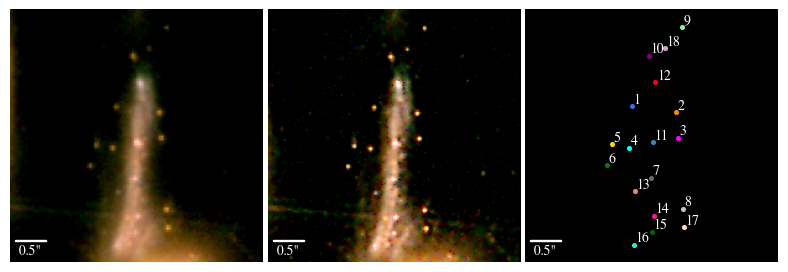

In [34]:
#prepare the RGB image: 
margin = 18
margin_up = 36
rgb_data, init_offset, a_init, b_init = prepare_image(R,G,B, framesize=im_size - margin, ref=True)
rgb_dec, _, _, _ = prepare_image(R_dec, G_dec, B_dec, framesize=im_size_up - margin_up, ref=False, init_offset=init_offset, a_init=a_init, b_init=b_init)
rgb_back, _, _, _ = prepare_image(R_back, G_back, B_back, framesize=im_size_up - margin_up, ref=False, init_offset=init_offset, a_init=a_init, b_init=b_init)

print(np.shape(rgb_data))
label = ['R','G','B']
for band in range(3):
    rgb_data[:,:,band] = coef_m[band]*rgb_data[:,:,band] + coef_a[band]
    rgb_dec[:,:,band] = coef_m[band]*rgb_dec[:,:,band] + coef_a[band]
    rgb_back[:,:,band] = coef_m[band]*rgb_back[:,:,band] + coef_a[band]

fig_rgb, axes = plt.subplots(1,3,figsize =(8,5))
plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02)

axes[0].imshow(rgb_data, origin = 'lower')
axes[1].imshow(rgb_dec, origin = 'lower')
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[0].yaxis.set_tick_params(labelleft=False)
axes[1].xaxis.set_tick_params(labelbottom=False)
axes[1].yaxis.set_tick_params(labelleft=False)
axes[0].axis("off")
axes[1].axis("off")

axes[2].imshow(np.zeros_like(rgb_dec), origin = 'lower')
axes[2].axis("off")
axes[2].axis("off")
# axes[2].xaxis.set_tick_params(labelbottom=False)
# axes[2].yaxis.set_tick_params(labelleft=False)

for i in range(N_new): 
    meanx = np.mean(x[i,:]) * subsampling_factor + im_size_up/2. - margin_up /2.
    meany = np.mean(y[i,:]) * subsampling_factor + im_size_up/2. - margin_up /2.

    axes[2].annotate( '%i'%(i+1), (meanx + 1.2, meany + 2.5), xycoords='data', color='white', fontsize=10)
    axes[2].scatter(meanx, meany, s =7, marker='o', c = color[i])

scalebar = AnchoredSizeBar(axes[0].transData,
                           12.5, '0.5"', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=0.5)
scalebar2 = AnchoredSizeBar(axes[1].transData,
                           25, '0.5"', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)
scalebar3 = AnchoredSizeBar(axes[2].transData,
                           25, '0.5"', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)

axes[0].add_artist(scalebar)
axes[1].add_artist(scalebar2)
axes[2].add_artist(scalebar3)

filename = os.path.join(output_folder, 'rgb_image.pdf')
fig_rgb.savefig(filename)
fig_rgb.savefig(os.path.join(output_folder, 'rgb_image.png'))

os.system('pdfcrop %s %s'%(filename, filename))

plt.show()